# Clustering
In this notebook, we are trying out various kmeans clustering approaches. We are working with a lagged fog state variable.

Ouyr best result is kmeans calculated using euclidean distance metrics. The results are as follows:

11106.969938929045 calinski_harabasz_score \
1.909700692952029 davies_bouldin_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install neptune-notebooks
!jupyter nbextension enable --py neptune-notebooks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 K

In [3]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1
!pip install -U neptune-client
!pip install -U neptune-sklearn
!pip install -U tslearn
!pip install missingno
!pip install hyperopt


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import neptune
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import missingno
from scipy import stats
import math

# clustering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint
from tslearn.utils import to_time_series_dataset
from tslearn import clustering,preprocessing
from sklearn.decomposition import PCA
from tslearn.clustering import KernelKMeans,TimeSeriesKMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

The scikit-learn version is 1.2.1.


/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version


In [5]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing directly from CA4021 folder


In [6]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot
from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model

In [7]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path,'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path,'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [8]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [9]:
# selected variables from XGBoost notebook + added lagged fog
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni','fog_state', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [10]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')
# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(df_train, df_test, 
                                     cat_vars=categorical, num_vars=continuous+discrete, cat_encoder='oh')
y_train = y.copy()
y_test = df_test[target]
# for compatibility with TimeSeriesSplit
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Time Series Kmeans

In [ ]:
X_train

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,fog_state_fog,fog_state_no fog,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
0,-1.376079,-0.362191,0.305680,-0.432978,-0.416469,-0.749357,-0.855241,-0.786384,-0.865935,1.170655,-0.002102,0.592468,-0.652624,-0.804416,0.770863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.376079,-0.573671,0.557907,-0.432978,-0.416469,-0.749357,-0.855241,-0.763574,-0.946414,1.170655,-0.002102,0.592468,-0.833040,-0.804416,0.892206,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.445887,0.060768,-0.198772,-0.432978,-0.416469,-0.749357,-0.855241,-1.060103,-0.906174,1.145849,-0.002102,0.592468,-0.833040,-1.035018,0.770863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.445887,-0.658263,0.641982,-0.418409,-0.416469,-0.749357,-0.855241,-0.695144,-0.926294,1.129312,0.027427,0.592468,-0.652624,-0.738529,0.528175,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.445887,-0.869742,0.978284,-0.403841,-0.416469,-0.749357,-0.855241,-0.603904,-0.946414,1.129312,0.056956,0.592468,-0.652624,-0.672643,0.892206,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78883,-0.887424,-0.362191,0.305680,-0.520389,-0.416469,-0.510474,-0.855241,-0.102086,-0.262339,1.418711,-0.385979,1.030708,-1.193872,-0.211437,-1.049294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
78884,-0.608192,0.103064,-0.282848,-0.491252,-0.416469,-0.480613,-0.855241,-0.352995,-0.262339,1.418711,-0.238334,1.030708,-0.833040,-0.474983,-0.806607,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78885,-0.608192,0.060768,-0.114697,-0.476683,-0.416469,-0.465683,-0.855241,-0.352995,-0.282458,1.393905,-0.238334,1.030708,-1.193872,-0.442040,-0.806607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78886,-0.259153,0.356839,-0.450999,-0.432978,-0.416469,-0.420893,-0.855241,-0.558285,-0.322698,1.369100,-0.208805,0.592468,-1.193872,-0.639699,-0.563919,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
X_train_kmeans = preprocessing.TimeSeriesScalerMinMax().fit_transform(X_train)

In [ ]:
X_train_kmeans

array([[[0.        ],
        [0.39811306],
        [0.66035932],
        ...,
        [0.54033094],
        [0.54033094],
        [0.54033094]],

       [[0.        ],
        [0.31507356],
        [0.75939843],
        ...,
        [0.54033094],
        [0.54033094],
        [0.54033094]],

       [[0.        ],
        [0.58133036],
        [0.48118896],
        ...,
        [0.55788356],
        [0.55788356],
        [0.94372521]],

       ...,

       [[0.22632546],
        [0.48483308],
        [0.41702791],
        ...,
        [0.46135041],
        [0.46135041],
        [0.84778238]],

       [[0.36470143],
        [0.60504428],
        [0.28984855],
        ...,
        [0.46581556],
        [0.46581556],
        [0.8559876 ]],

       [[0.36352863],
        [0.53730015],
        [0.35431325],
        ...,
        [0.46431761],
        [0.46431761],
        [0.46431761]]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   16.2s finished


0.971 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   20.0s finished


0.649 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   19.2s finished


0.611 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   15.2s finished


0.602 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   14.6s finished


0.599 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   16.1s finished


0.594 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   14.4s finished


0.592 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   14.6s finished


0.591 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   14.6s finished


0.588 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   16.4s finished


0.583 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   18.6s finished


0.583 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157776 out of 157776 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   34.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   31.6s finished


0.707 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   26.1s finished


0.529 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   37.7s finished


0.524 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   31.1s finished


0.522 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   38.4s finished


0.520 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   30.0s finished


0.520 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   31.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   31.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   33.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   30.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   40.1s finished


0.662 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   41.1s finished


0.485 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   34.8s finished


0.474 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   43.4s finished


0.469 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   35.6s finished


0.467 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   36.5s finished


0.466 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   35.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   28.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.633 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   49.8s finished


0.470 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   45.3s finished


0.457 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   46.4s finished


0.452 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   60.0s finished


0.450 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   55.1s finished


0.450 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 394440 out of 394440 | elapsed:   55.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   30.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.610 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.0min finished


0.454 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.2min finished


0.442 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.3min finished


0.437 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.1min finished


0.435 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.2min finished


0.434 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 473328 out of 473328 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   24.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.585 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.5min finished


0.435 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.7min finished


0.425 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.3min finished


0.421 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.3min finished


0.420 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.3min finished


0.419 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 552216 out of 552216 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   36.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   41.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.565 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.7min finished


0.430 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.6min finished


0.420 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.8min finished


0.417 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.8min finished


0.415 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.9min finished


0.414 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.9min finished


0.414 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   37.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   46.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   35.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   37.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.553 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  3.4min finished


0.424 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  2.9min finished


0.413 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  2.8min finished


0.409 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  2.9min finished


0.407 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  3.4min finished


0.406 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  4.0min finished


0.406 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 709992 out of 709992 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   49.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.546 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  3.5min finished


0.418 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  3.4min finished


0.406 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  3.5min finished


0.401 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  4.1min finished


0.399 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  4.2min finished


0.398 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  5.0min finished


0.398 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 788880 out of 788880 | elapsed:  2.8min finished


Text(0, 0.5, 'WCSS')

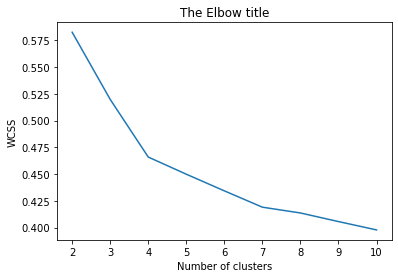

In [ ]:
# do not rerun!!!!

wcss=[]
for i in range(2,11):
  kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw",verbose=True,random_state=seed,tol=0.001)
  kmeans.fit(X_train_kmeans)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(2,11)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

From above plot, we will choose k = 4

In [ ]:
km = TimeSeriesKMeans(n_clusters=4,metric='dtw',max_iter=3000,verbose=True,random_state=seed, tol=0.001)
y_pred_4 = km.fit_predict(X_train_kmeans)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   34.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   32.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236664 out of 236664 | elapsed:   32.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   47.7s finished


0.662 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:  1.1min finished


0.485 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   54.9s finished


0.474 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   47.4s finished


0.469 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   47.2s finished


0.467 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   48.0s finished


0.466 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   46.8s finished


In [ ]:
print(metrics.calinski_harabasz_score(X_train_kmeans.reshape(78888,26), y_pred_4))
print(metrics.davies_bouldin_score(X_train_kmeans.reshape(78888, 26), y_pred_4))


7668.603282052929
2.7213938149927035


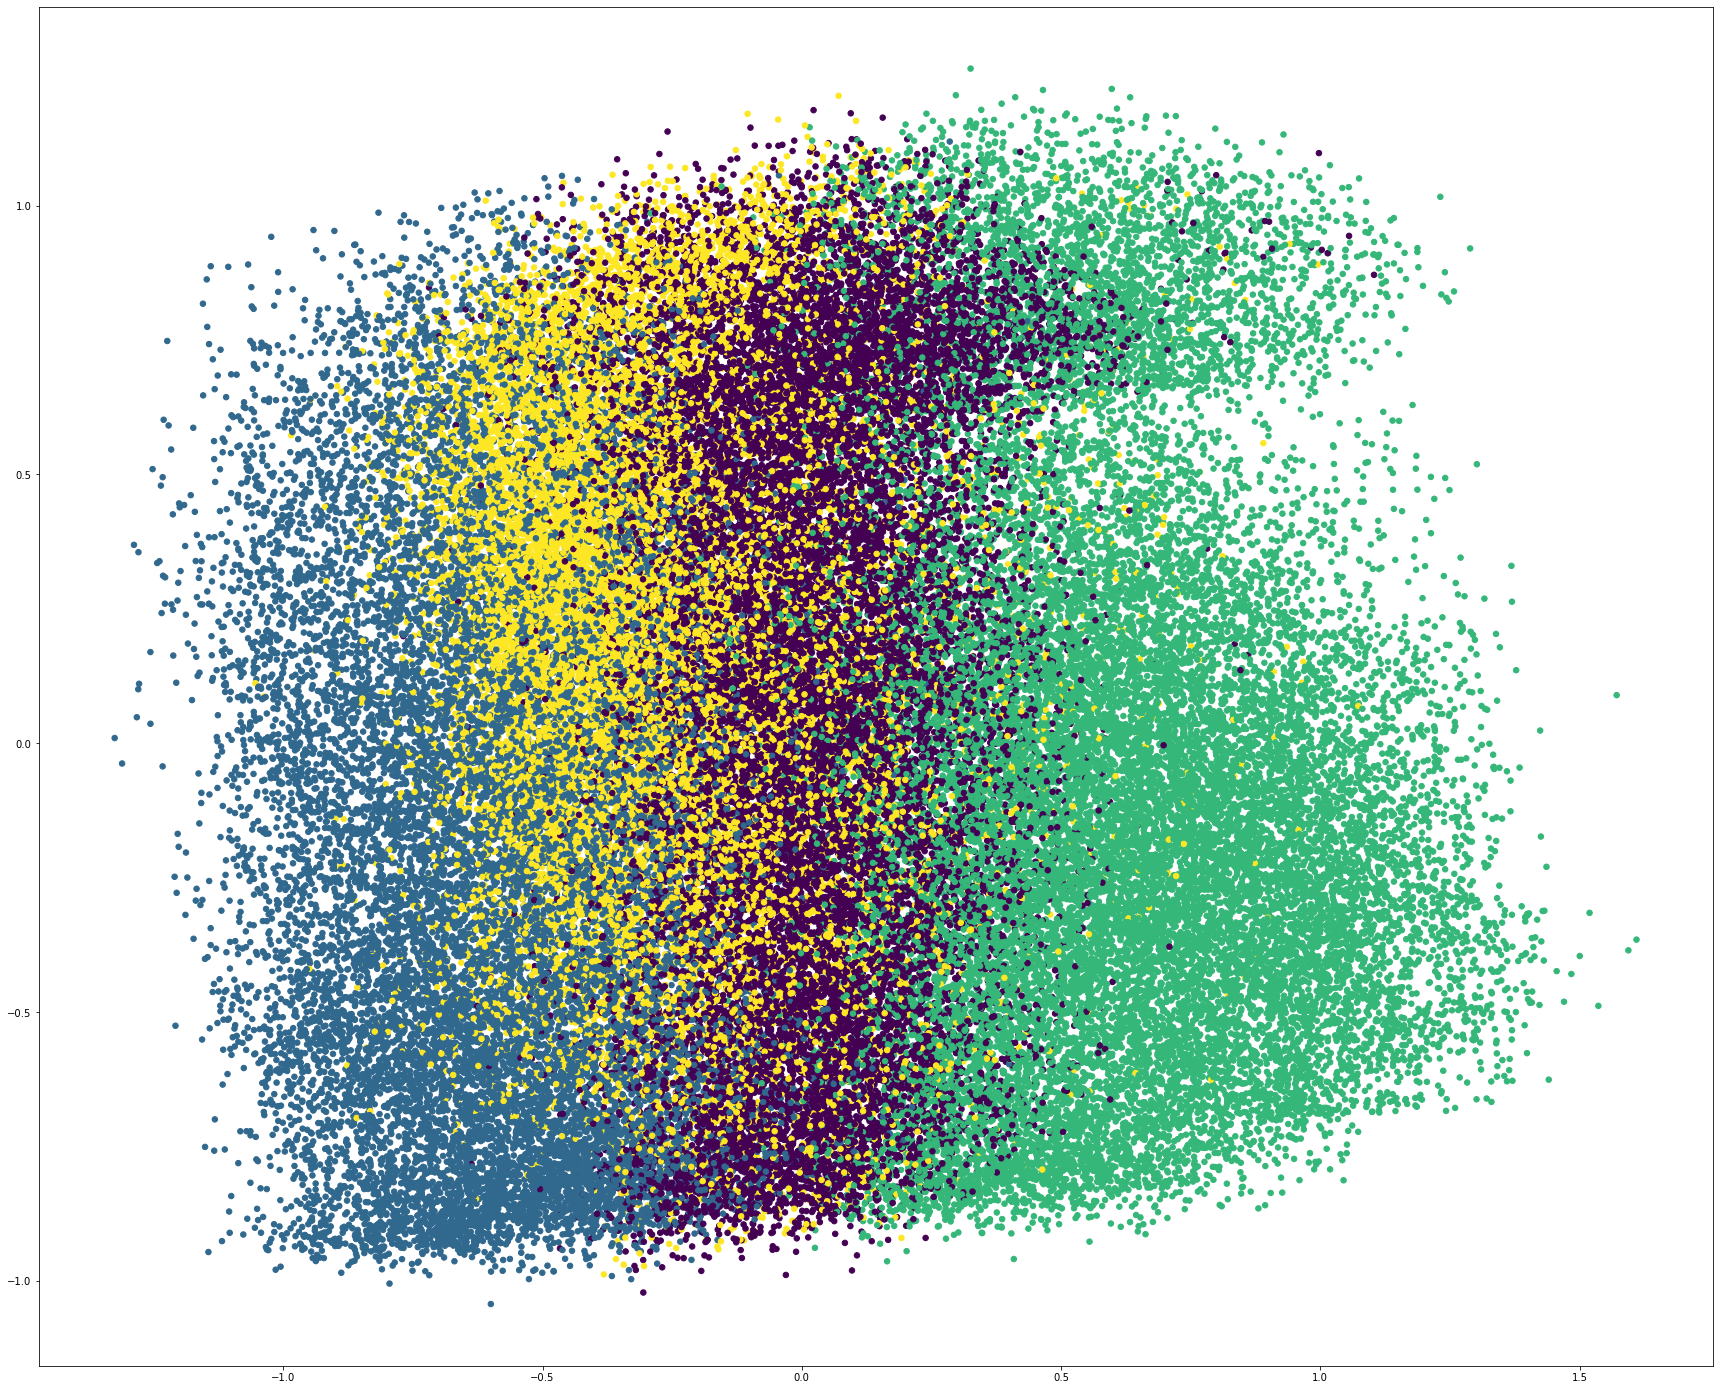

In [ ]:

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train_kmeans.reshape(78888,26))
plt.figure(figsize=(30, 25))
plt.scatter(X_transformed[:, 0],
            X_transformed[:, 1], c=y_pred_4, s=30)
plt.show()


In [ ]:
#X_train_kmeans = preprocessing.TimeSeriesScalerMinMax().fit_transform(X_train)
#X_train_kmeans=X_train_kmeans.reshape(78888,26)
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_kms = TimeSeriesKMeans(n_clusters=4,
                           metric="softdtw", tol=0.001,
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=42)
y_pred_softs = sdtw_kms.fit_predict(X_train_kmeans)



Soft-DTW k-means
0.443 --> 0.183 --> 0.171 --> 0.165 --> 0.161 --> 0.160 --> 0.159 --> 


In [ ]:
print(metrics.calinski_harabasz_score(X_train_kmeans.reshape(78888,26), y_pred_softs))
print(metrics.davies_bouldin_score(X_train_kmeans.reshape(78888,26), y_pred_softs))

7602.373617225446
2.7718331641230503


In [ ]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train_kmeans.reshape(78888,26))
plt.figure(figsize=(30, 25))
plt.scatter(X_transformed[:, 0],
            X_transformed[:, 1], c=y_pred_softs, s=30)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
print("Normal kmeans")
kms_normal = TimeSeriesKMeans(n_clusters=4,
                           metric="euclidean", tol=0.001,
                           verbose=True,
                           random_state=42,)
y_pred_normal = kms_normal.fit_predict(X_train_kmeans)

Normal kmeans
1.610 --> 1.207 --> 1.180 --> 1.166 --> 1.148 --> 1.118 --> 1.099 --> 1.092 --> 1.090 --> 1.089 --> 


In [ ]:
print(metrics.calinski_harabasz_score(X_train_kmeans.reshape(78888,26), y_pred_normal))
print(metrics.davies_bouldin_score(X_train_kmeans.reshape(78888,26), y_pred_normal))

11106.969938929045
1.909700692952029


In [13]:
y_pred = [str(x) for x in y_pred_normal]
X_train['clusters'] = y_pred
X_train['fog_state_fog'] = X_train['fog_state_fog'].apply(str)

In [35]:
from bokeh.models import LinearInterpolator
from bokeh.plotting import figure, output_notebook, show
from bokeh.models.tools import HoverTool
from bokeh.resources import INLINE
from bokeh.transform import factor_cmap,factor_mark
from bokeh.palettes import Spectral6,viridis,inferno
output_notebook(INLINE)
#loc[X_train['fog_state_fog'] == 1]

p = figure(plot_width=900, plot_height=750, title = "Fog and no fog",
          toolbar_location='right',
          tools=["hover","box_zoom","wheel_zoom", "pan",'undo','save'], tooltips="Visibility: @vis , Ceiling: @ceiling, Fog: @fog_state_fog")

p.scatter(x='dewpt',y='temp_dew_dist',
          source=X_train,
          fill_alpha=0.7,size=8, marker=factor_mark('fog_state_fog', ['circle','triangle'], ['0.0','1.0']),fill_color=factor_cmap('clusters', palette=viridis(4), factors=['0','1','2','3']))
p.xaxis.axis_label = 'dewpt'
p.yaxis.axis_label = 'temp_dew_dist'
p.toolbar.autohide = True
show(p)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
from bokeh.models import LinearInterpolator
from bokeh.plotting import figure, output_notebook, show
from bokeh.models.tools import HoverTool
from bokeh.resources import INLINE
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6,viridis,inferno
output_notebook(INLINE)
#loc[X_train['fog_state_fog'] == 1]

p = figure(plot_width=900, plot_height=750, title = "Fog occurences",
          toolbar_location='right',
          tools=["hover","box_zoom","wheel_zoom", "pan",'undo','save'], tooltips="Visibility: @vis , Ceiling: @ceiling, Fog: @fog_state_fog")

p.scatter(x='dewpt',y='temp_dew_dist',
          source=X_train.loc[X_train['fog_state_fog'] == '1.0'],
          fill_alpha=0.7,size=10, marker=factor_mark('fog_state_fog', ['circle','triangle'], ['0.0','1.0']),fill_color=factor_cmap('clusters', palette=viridis(4), factors=['0','1','2','3']))
p.xaxis.axis_label = 'dewpt'
p.yaxis.axis_label = 'tempdewdist'
p.toolbar.autohide = True
show(p)

Output hidden; open in https://colab.research.google.com to view.

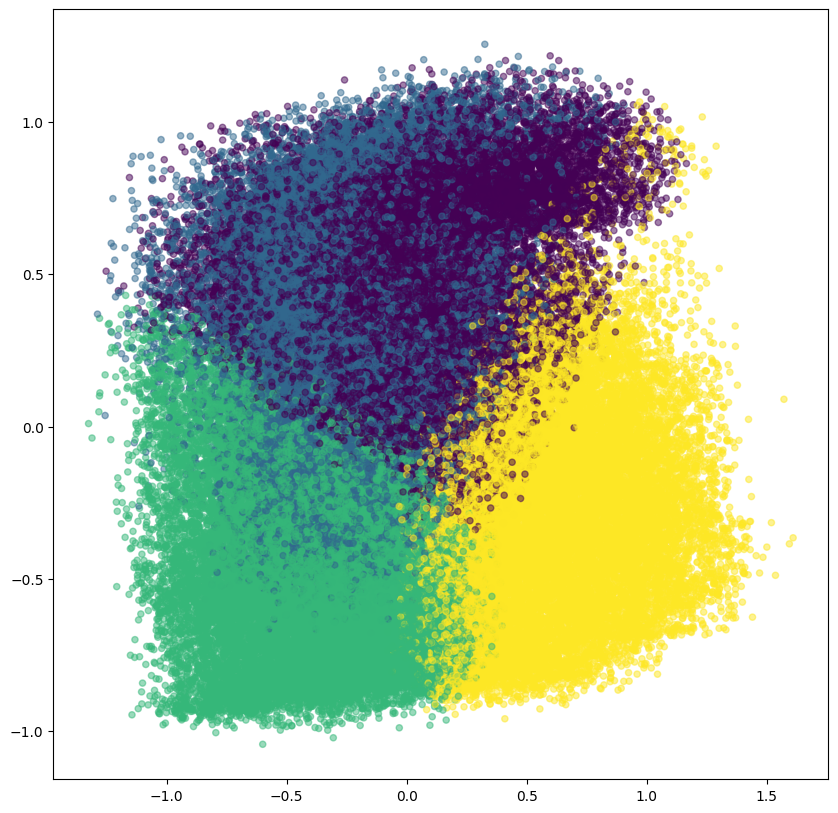

In [ ]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train_kmeans.reshape(78888,26))
plt.figure(figsize=(10,10))
plt.scatter(X_transformed[:,0],
            X_transformed[:,1], c=y_pred_normal, s=20,alpha=0.5)
plt.show()

In [ ]:
# Save the best object to a file (this will be euclidean kmeans)
with open(os.path.join(path, 'results/kmeans_lagged_object.pickle'), "wb") as file:
    pickle.dump(kms_normal, file)

In [ ]:
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [ ]:
cluster_report(X_train, y_pred_normal, min_samples_leaf=50, pruning_level=0.1)

,class_name,instance_count,rule_list
1,0,20169,[0.6235238545111006] (temp_dew_dist <= 0.4625790864229202) and (dewpt > 0.0005586245097219944)
3,1,18370,[0.756543354291563] (temp_dew_dist > 0.4625790864229202)
0,2,20851,[0.6003549925173146] (temp_dew_dist <= 0.4625790864229202) and (dewpt <= 0.0005586245097219944)
2,3,19498,NaN
